## PHYS-85200 - Machine Learning for Physicists
### Student: Gehan Ranepura
### Worksheet #4

In [2]:
import pandas as pd
import numpy as np
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import linear_model #New!
from sklearn.linear_model import RidgeCV #New!
from sklearn.linear_model import Ridge, Lasso, LassoCV #New!
from sklearn import metrics 
from sklearn.pipeline import make_pipeline
from scipy import stats

from io import StringIO  
from IPython.display import Image  
import pydotplus

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
font = {'size'   : 20}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rcParams['figure.dpi'] = 300

## Refer to the data with outliers that we generated at the end of the notebook "Linear Regression" from March 23.

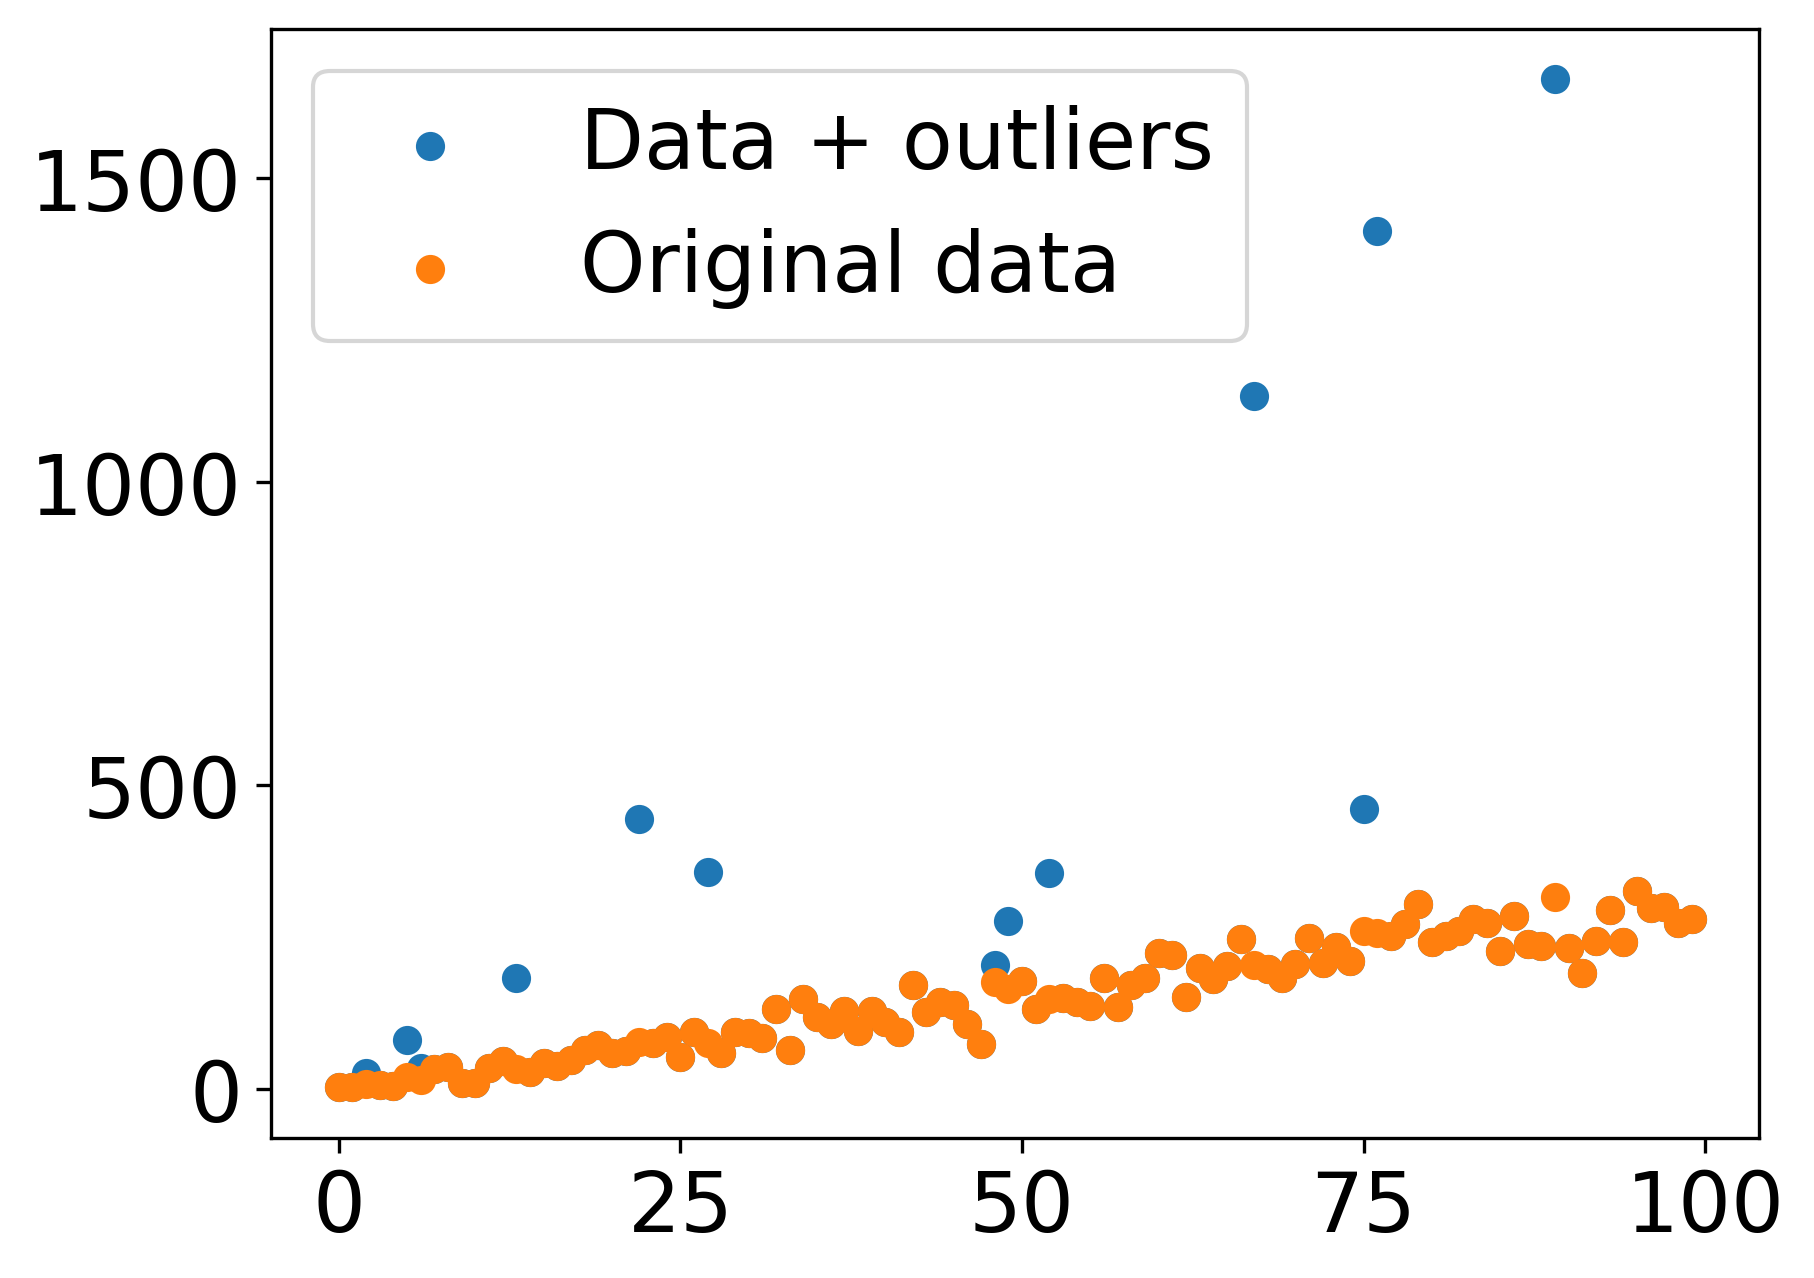

In [3]:
np.random.seed(16)                                      #set seed for reproducibility purposes
x = np.arange(100) 
yp = 3*x + 3 + 2*(np.random.poisson(3*x+3,100)-(3*x+3)) #generate some data with scatter following Poisson distribution 
                                                        #with exp value = y from linear model, centered around 0

np.random.seed(12)             #set 
out = np.random.choice(100,15) #select 15 outliers indexes
yp_wo = np.copy(yp)
np.random.seed(12)             #set again
yp_wo[out] = yp_wo[out] + 5*np.random.rand(15)*yp[out]

plt.scatter(x, yp_wo, label = 'Data + outliers')
plt.scatter(x, yp,    label = 'Original data')
plt.legend();

### 1) Using the example of the grid of parameters beta0, beta1 for the MSE (also found in the same notebook, a bit earlier) as an example, find the best coefficients for the MSE and two more losses: the MAE and the MAPE (Mean or Median Absolute Percentage Error, also defined in the notebook). 

#### theta0             =  1.54818,  theta1             = 3.9784

#### MSE_theta0   =   0.72864, MSE_theta1   = 3.99497

#### MAE_theta0   =   0.22613, MAE_theta1   = 3.09045

#### MAPE_theta0 = -0.87939, MAPE_theta1 = 2.88944

### MSE (Mean Squared Error)
$$ MSE = \frac {\sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2} {N} $$  

In [4]:
# Linear Regression Model
model = linear_model.LinearRegression()
model.fit(x.reshape(-1,1),yp_wo) 
slope, intercept = model.coef_, model.intercept_
print("slope = {}, intercept = {}".format(slope, intercept))

# Analytical Solution
theta1 = np.cov(x,yp_wo, bias=True)[0,1]/np.var(x)
theta0 = np.mean(yp_wo) - theta1*np.mean(x)
print('Analytic_Theta_0 = {}, Analytic_Theta_1 = {}'.format(theta0, theta1))

# Grid Search MSE 
theta0 = np.linspace(-5,5,200)
theta1 = np.linspace(-5,5,200)

mse = np.empty((200,200))
for i,t0 in enumerate(theta0):
    for j,t1 in enumerate(theta1):
        mse[i,j] = np.sum((t0 + t1*x - yp_wo)**2)/len(yp_wo)

# To get the indices of the 2D array, I need to unravel it
print("MSE argmin:", mse.argmin())
print("Shape:"     , np.unravel_index(mse.argmin(), mse.shape))

# I can now find the minimum MSE (not very informative, TBH) and the best fit coefficients
print("Min MSE:", mse[114, 179] )
MSEtheta0, MSEtheta1 = theta0[114], theta1[179]
print("minMSEtheta0 = {}, minMSEtheta1 = {}".format(MSEtheta0, MSEtheta1))

slope = [3.97842184], intercept = 1.5481188118811815
Analytic_Theta_0 = 1.5481188118812383, Analytic_Theta_1 = 3.9784218421842175
MSE argmin: 22979
Shape: (114, 179)
Min MSE: 43259.30993762784
minMSEtheta0 = 0.7286432160804024, minMSEtheta1 = 3.9949748743718594


### MAE (Mean Absolute Error)
$$ MAE = \frac {\sum_{i=1}^N \left| \left( y_i - \hat{y}_i) \right) \right|} {N} $$  

In [5]:
# Grid Search MAE
theta0 = np.linspace(-5,5,200)
theta1 = np.linspace(-5,5,200)

mae = np.empty((200,200))
for i,t0 in enumerate(theta0):
    for j,t1 in enumerate(theta1):
        mae[i,j] = np.sum(np.sqrt((t0 + t1*x - yp_wo)**2))/len(yp_wo)

# To get the indices of the 2D array, I need to unravel it
print("MAE argmin:", mae.argmin())
print("Shape:"     , np.unravel_index(mae.argmin(), mae.shape))

# I can now find the minimum MAE (not very informative, TBH) and the best fit coefficients
MAEtheta0, MAEtheta1 = theta0[104], theta1[161]
print("minMSEtheta0 = {}, minMSEtheta1 = {}".format(MAEtheta0, MAEtheta1))

MAE argmin: 20961
Shape: (104, 161)
minMSEtheta0 = 0.22613065326633208, minMSEtheta1 = 3.090452261306533


### MAPE (Mean Absolute Percentage Error)
$$ MAE = \frac {\sum_{i=1}^N \left| \left( \frac {y_i - \hat{y}_i}{\hat{y}_i} \right) \right|} {N} $$ 

In [6]:
# Grid Search MAPE
theta0 = np.linspace(-5,5,200)
theta1 = np.linspace(-5,5,200)

mape = np.empty((200,200))
for i,t0 in enumerate(theta0):
    for j,t1 in enumerate(theta1):
        mape[i,j] = np.sum(np.sqrt(((t0 + t1*x - yp_wo)/yp_wo)**2))/len(yp_wo)
                           
# To get the indices of the 2D array, I need to unravel it
print("MAPE argmin", mape.argmin())
print("Shape:"     , np.unravel_index(mape.argmin(), mape.shape))

# I can now find the minimum MAE (not very informative, TBH) and the best fit coefficients
MAPEtheta0, MAPEtheta1 = theta0[82], theta1[157]
print("minMSEtheta0 = {}, minMSEtheta1 = {}".format(MAPEtheta0, MAPEtheta1))

MAPE argmin 16557
Shape: (82, 157)
minMSEtheta0 = -0.8793969849246226, minMSEtheta1 = 2.8894472361809047


### 2) Plot the best fit line for the MSE loss, the MAE loss, and the MAPE loss. Are they similar or different? 
### Can you explain the reasons of any difference?

They are similar

Text(0, 0.5, 'Y')

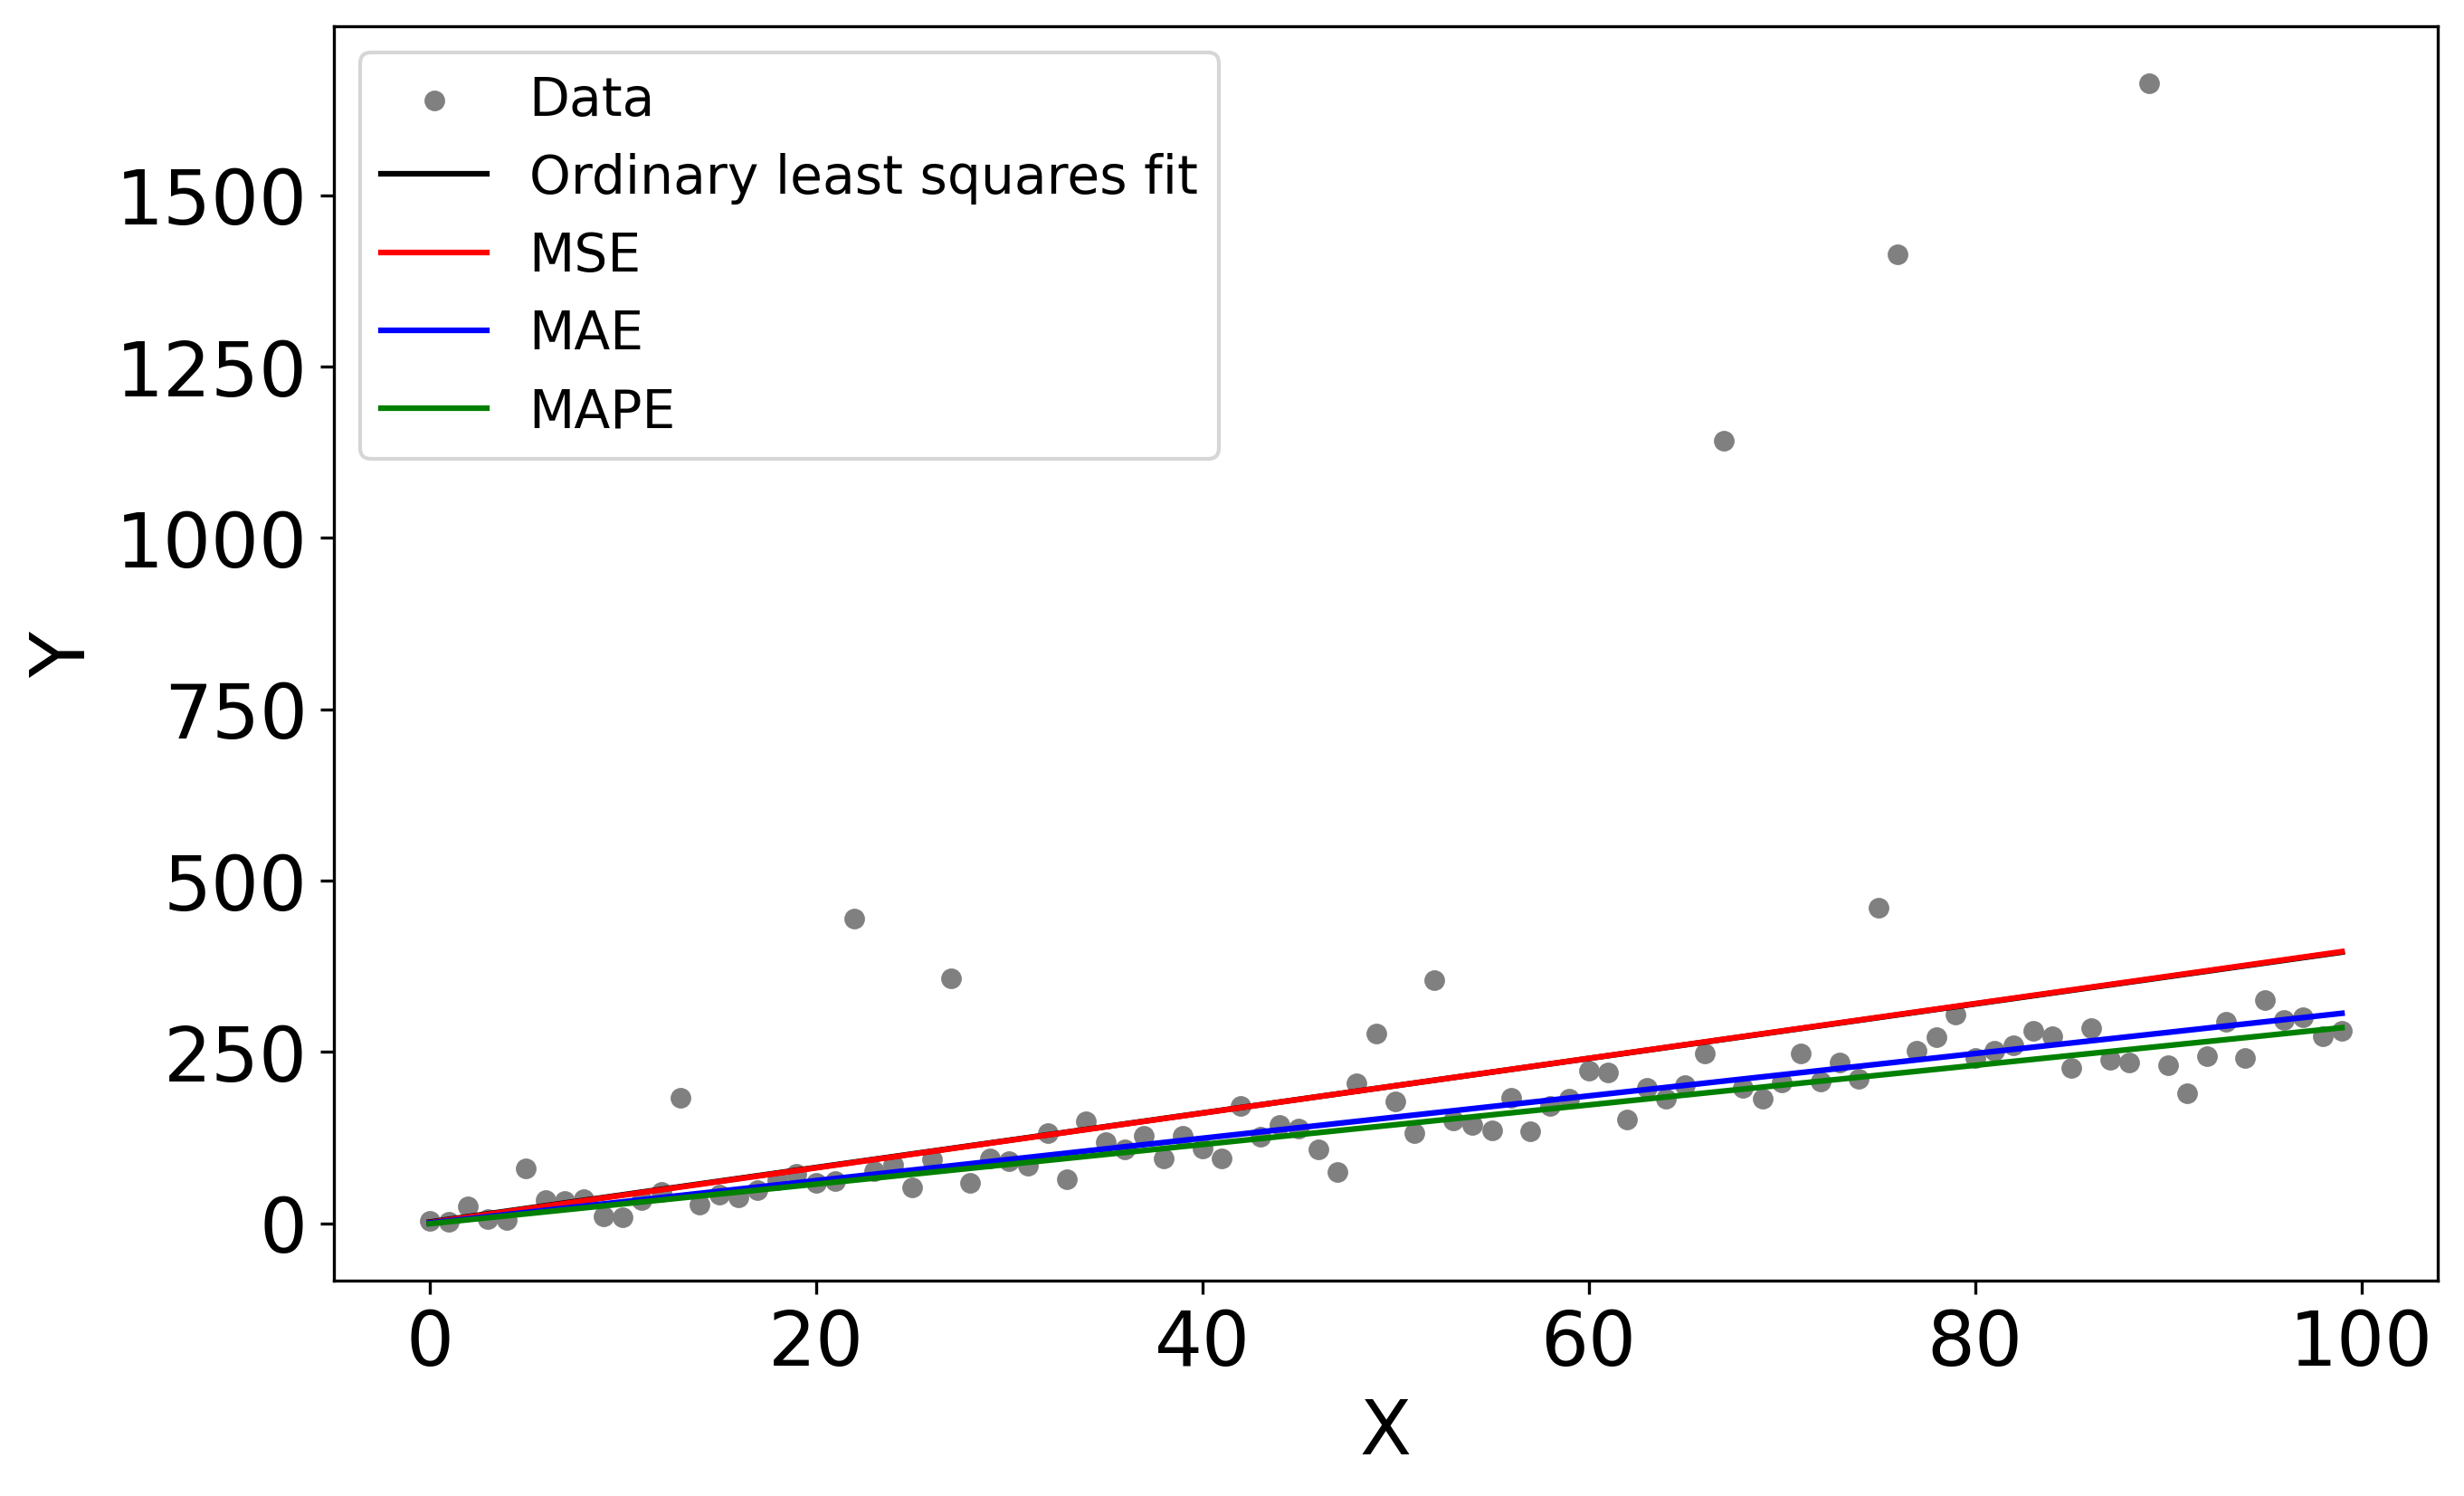

In [7]:
plt.figure(figsize = (10,6))
plt.scatter(x,yp_wo, s = 20, c = 'gray', label = 'Data')
plt.plot(x, slope*x + intercept , c ='k', label = 'Ordinary least squares fit')
plt.plot(x, MSEtheta1*x  + MSEtheta0,  c = 'r', label = 'MSE')
plt.plot(x, MAEtheta1*x  + MAEtheta0,  c = 'b', label = 'MAE')
plt.plot(x, MAPEtheta1*x + MAPEtheta0, c = 'g', label = 'MAPE')
plt.legend(fontsize = 14)
plt.xlabel('X')
plt.ylabel('Y')

### Now, generate some poly features data (new_xb, ypb) using the following code:

In [8]:
x1 = np.arange(100)
x2 = np.linspace(0,1,100)
x3 = np.logspace(2,3,num=100)
xb = np.vstack((x1,x2,x3)).T
poly = PolynomialFeatures(3, include_bias=False)
new_xb = poly.fit_transform(xb)
np.random.seed(10)
ypb = 2*x1 + 4*x2 + 5*x3 + 3 + 10*(np.random.normal(0,10,size=100))

### 3) Apply Ridge Regression to the same data, and use cross validation to choose the optimal parameter alpha (you can use values of alpha = 10^-5, 10^-4, 10^-3, ... 10^3). 
#### You can use the examples in the "Regularization" notebook. Which value gives you the lowest MSE?
### EC: use a pipeline to standardize the data, so you don't have to deal with the annoying deprecation warning for "normalize".

- The best alpha was 0.01, where the lowest MSE = 9832

In [12]:
MSE = []

for alpha in np.logspace(-6,6,13):

    #model_reg = Ridge(alpha = alpha, normalize = True) #normalization helps
    # Use make_pipeline to standarize data to rid if deprecation warning 
    model = Ridge(alpha, normalize = True) 
    model_reg = make_pipeline(StandardScaler(with_mean=False), model)

    scores = cross_validate(model_reg, new_xb, ypb, cv = KFold(n_splits=5, shuffle=True, random_state = 1), scoring = 'neg_mean_squared_error')

    print(alpha, np.round(-np.mean(scores['test_score'])))
    
    MSE.append(-np.mean(scores['test_score']))

print('Best alpha:', np.logspace(-6,6,13)[np.argmin(MSE)])

1e-06 10781.0
1e-05 10676.0
0.0001 10465.0
0.001 10127.0
0.01 9843.0
0.1 10383.0
1.0 25245.0
10.0 247584.0
100.0 1281957.0
1000.0 1722598.0
10000.0 1779059.0
100000.0 1784860.0
1000000.0 1785442.0
Best alpha: 0.01


/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce th

[4.30194217e-02 4.25892275e+00 5.09584801e-03 4.35625510e-04
 4.31269255e-02 4.69914552e-05 4.26956562e+00 4.65215407e-03
 4.89132658e-06 4.56746826e-06 4.52179357e-04 4.80060901e-07
 4.47657564e-02 4.75260292e-05 4.94175781e-08 4.43180988e+00
 4.70507690e-03 4.89234023e-06 5.02123147e-09 2.05036076e+03]
[ 5.81261369e+00  5.75448755e+02  3.88629453e-01  3.59092439e-02
  3.55501514e+00  2.60073962e-03  3.51946499e+02  2.57473222e-01
  1.51018861e-04  2.32425818e-04  2.30101560e-02  1.49166848e-05
  2.27800544e+00  1.47675180e-03  6.27607691e-07  2.25522539e+02
  1.46198428e-01  6.21331615e-05 -2.50007565e-08  4.85545646e+02]
[ 5.95109793e+00  5.89158695e+02  2.53867297e-01  5.22394456e-02
  5.17170511e+00 -1.51768139e-03  5.11998806e+02 -1.50250459e-01
  9.07077701e-04  2.46342272e-04  2.43878850e-02 -6.72016345e-05
  2.41440061e+00 -6.65296181e-03  2.33660701e-05  2.39025660e+02
 -6.58643221e-01  2.31324094e-03 -2.49927890e-06  4.88418243e+02]


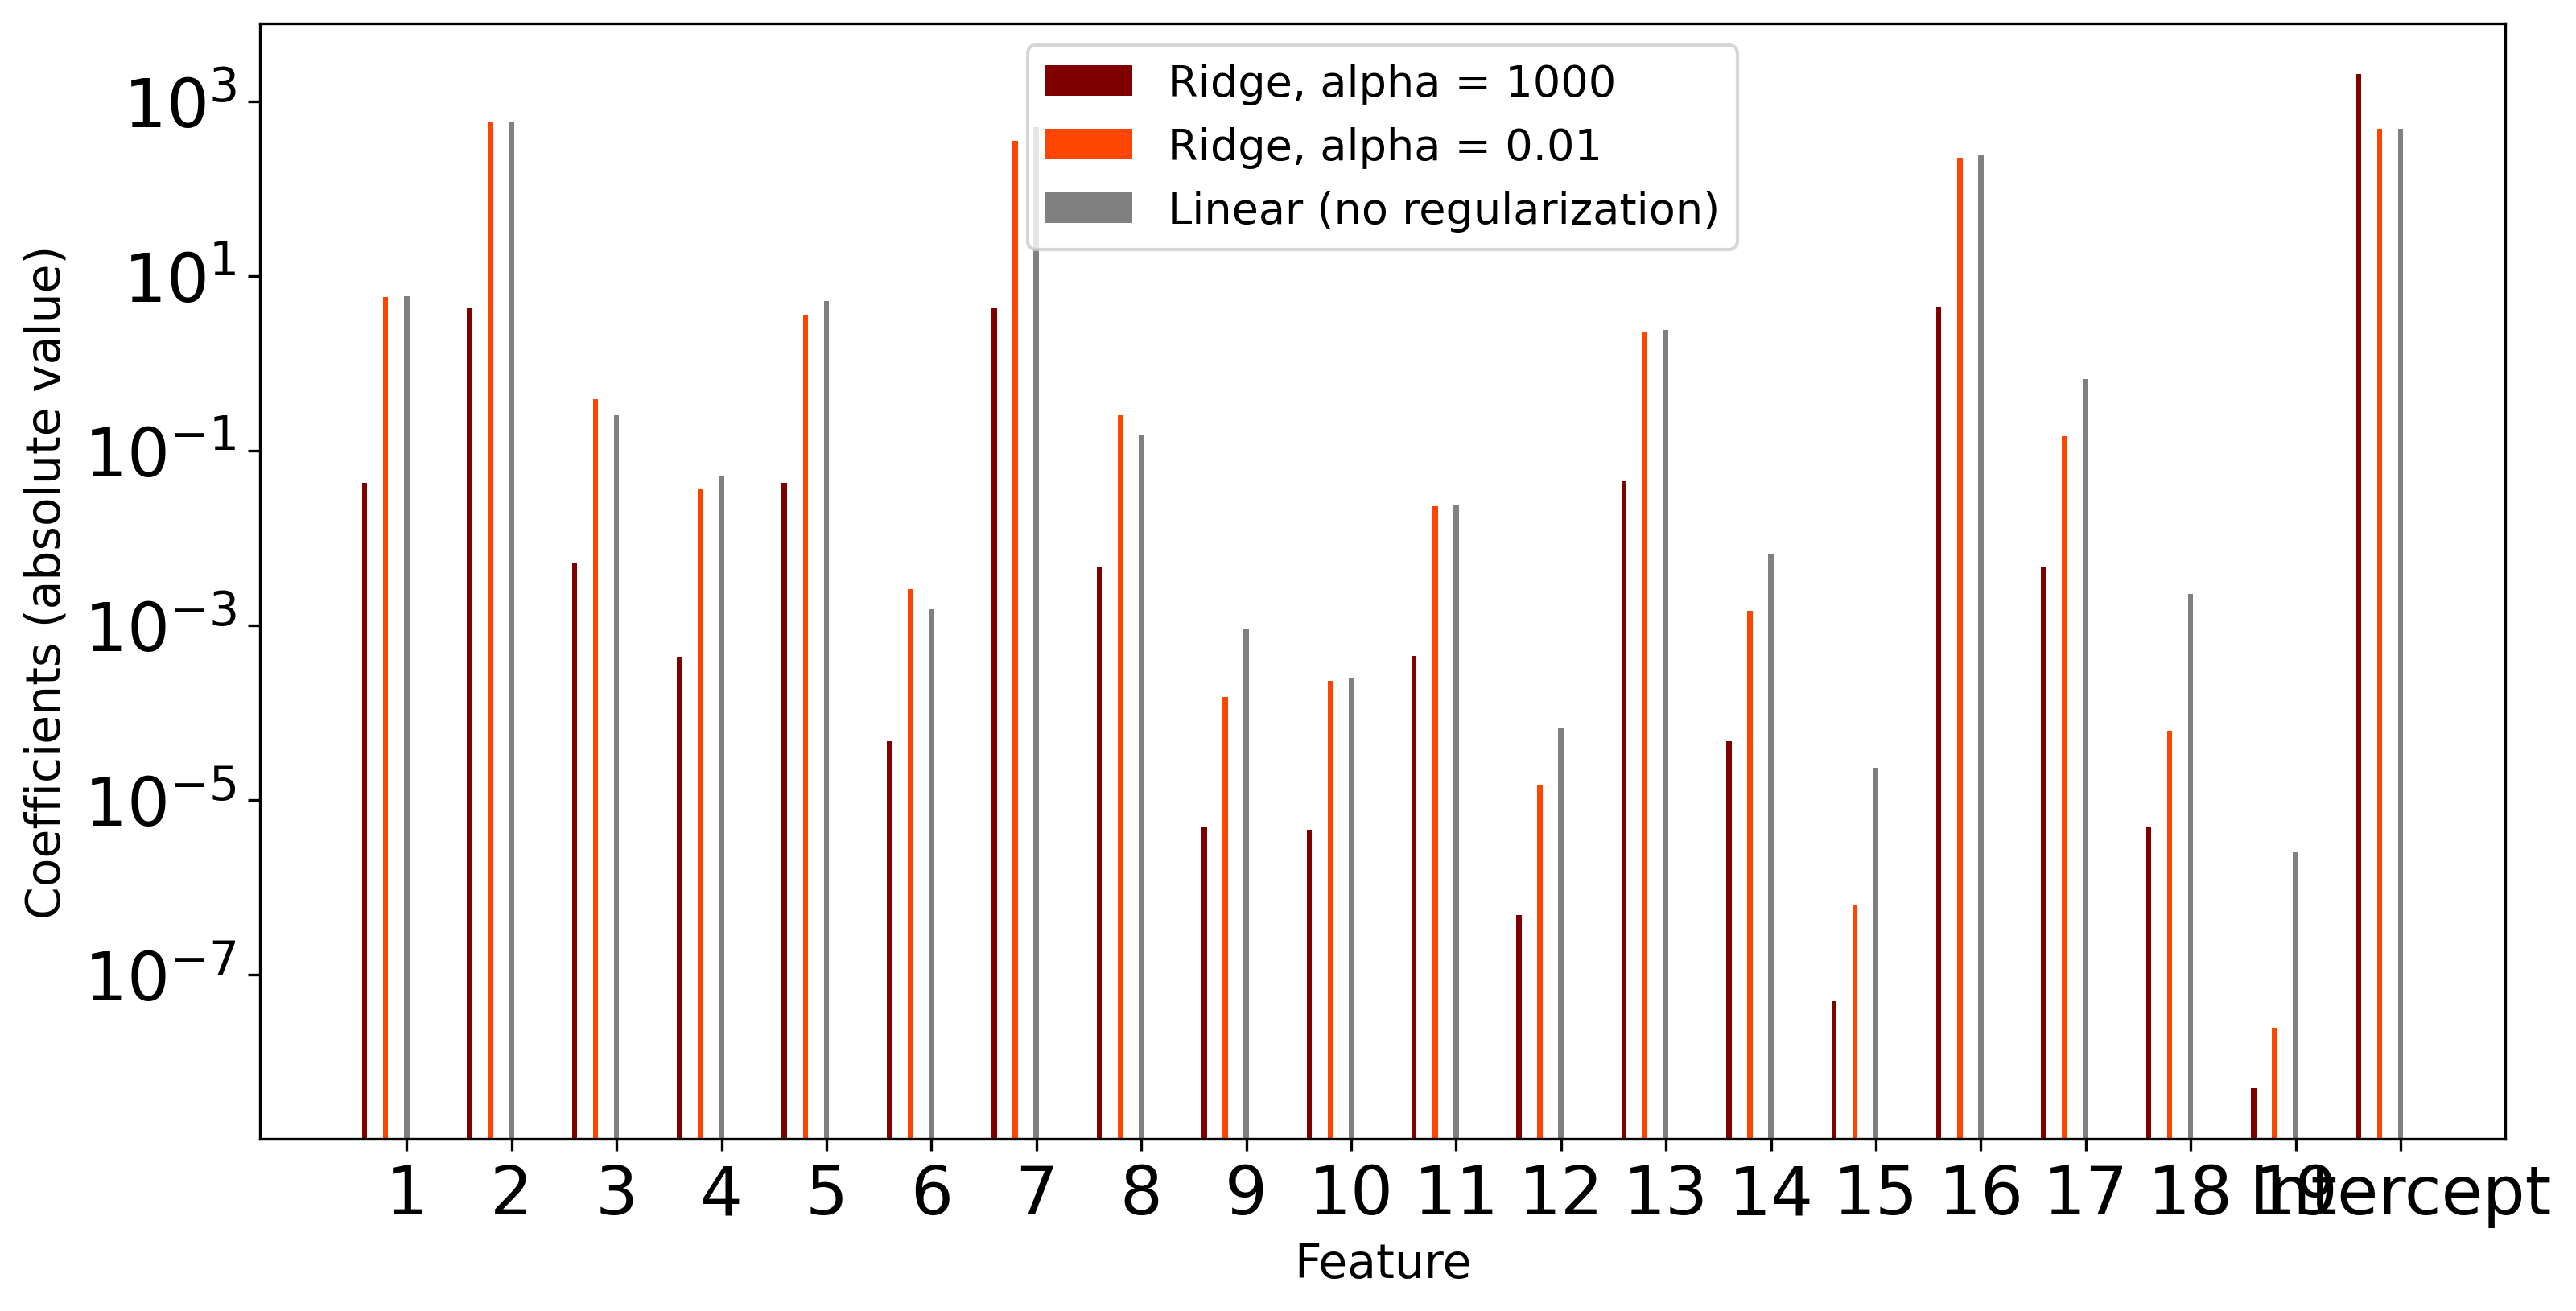

In [14]:
model = Ridge(alpha = 1000., normalize = True)
model.fit(new_xb,ypb)
coef_alpha_1000 =  np.hstack([model.coef_, model.intercept_]) #Note the intercept is the last number
print(coef_alpha_1000)

model = Ridge(alpha = 0.01, normalize = True)
model.fit(new_xb,ypb)
coef_alpha_01 =  np.hstack([model.coef_, model.intercept_]) #Note the intercept is the last number
print(coef_alpha_1)

model = Ridge(alpha = 1e-6, normalize = True)
model.fit(new_xb,ypb)
coef_no_reg =  np.hstack([model.coef_, model.intercept_])
print(coef_no_reg)

plt.figure(figsize = (12,6))
plt.bar(np.arange(20)-0.4, np.abs(coef_alpha_1000), color = 'maroon',width=0.05, label = 'Ridge, alpha = 1000')
plt.bar(np.arange(20)-0.2, np.abs(coef_alpha_01), color = 'orangered',width=0.05, label = 'Ridge, alpha = 0.01')
plt.bar(range(20), np.abs(coef_no_reg), color = 'grey',width=0.05, label = 'Linear (no regularization)')
plt.yscale('log')

plt.xticks(np.arange(20), ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','Intercept'])  # Set text labels.
plt.xlabel('Feature',fontsize=14)
plt.ylabel('Coefficients (absolute value)',fontsize=14)
plt.legend(fontsize=13);

### 4) On the basis of your answer in Q3, do you think these data require regularization or not?

- Yes, I think this data needs some sort of regularization because the coefficients change for higher values of alpha such thatthey are getting closer to 0.

Answer
- The coefficients are expected to change, what we’d look at is the value of alpha that gives the minimum loss. If it’s significantly different from zero, we’d say that the data require regularization

### 5) Repeat the process with Lasso Regression and print the coefficients (not the scores). For what minimum value of alpha do you find that at least half the coefficients are zero?

#### Note: to avoid convergence errors, you might need to increase the maximum number of iterations to a large number and start from a minimum value of alpha = 0.001.
#### Note 2: if you build a pipeline to scale your data, your model will have two pieces (the scaler + the regressor). To access the coefficients, you need to select the relevant piece, for example: model[1].coef_

- Starting from alpha value = 0.1, I see that at least half the cofficients are ~0.

In [74]:
#Note: LassoCV re-orders alphas in DESCENDING ORDER! Scores will be messed up unless you use model.alphas_ object

#model = LassoCV(alphas = np.logspace(-2,2,5), cv = KFold(n_splits=5, shuffle=True, random_state=1), \
#              max_iter = 1000000, tol = 1e-6, normalize=True)

model = make_pipeline(StandardScaler(with_mean=False), LassoCV(alphas = np.logspace(-2,2,5), cv = KFold(n_splits=5, shuffle=True, random_state=1), \
              max_iter = 1000000, tol = 1e-6, normalize=True))
model.fit(new_xb,ypb)
print('Alphas', model[1].alphas_)
print('Best alpha:', model[1].alpha_)

for i, alpha in enumerate(model[1].alphas_):
    print('Score for alpha', alpha, np.mean(model[1].mse_path_[i,:])) #for each alpha (row), 10 cv estimates of MSE
model[1].coef_

Alphas [1.e+02 1.e+01 1.e+00 1.e-01 1.e-02]
Best alpha: 1.0
Score for alpha 100.0 848563.9118331268
Score for alpha 10.0 18714.17143973387
Score for alpha 1.0 10051.24945963854
Score for alpha 0.1 10246.923298077434
Score for alpha 0.01 10328.632625149467


/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


array([6.05811298e+01, 2.20865104e-11, 1.19448884e+03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.87871620e+01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/granepura/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

coef_L1000 = [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.         2074.31080152]
coef_L100 = [0.00000000e+00 0.00000000e+00 1.23168825e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.59090540e+03]
coef_L1 = [1.07588084e+01 4.11836128e-12 2.29917624e+00 7.25673735e-03
 0.00000000e+00 5.52345081e-03 8.74651381e+00 0.00000000e+00
 4.92290789e-04 1.55913327e-04 1.20999020e-17 0.00000000e+00
 4.52355923e-01 0.00000000e+00 9.30057134e-07 1.75084986e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.49659241e+02]
coef_L_1 = [ 1.05249874e+01  4.51923135e-12  2.53870895e+00  1.31059444e-02
  0.00000000e+00

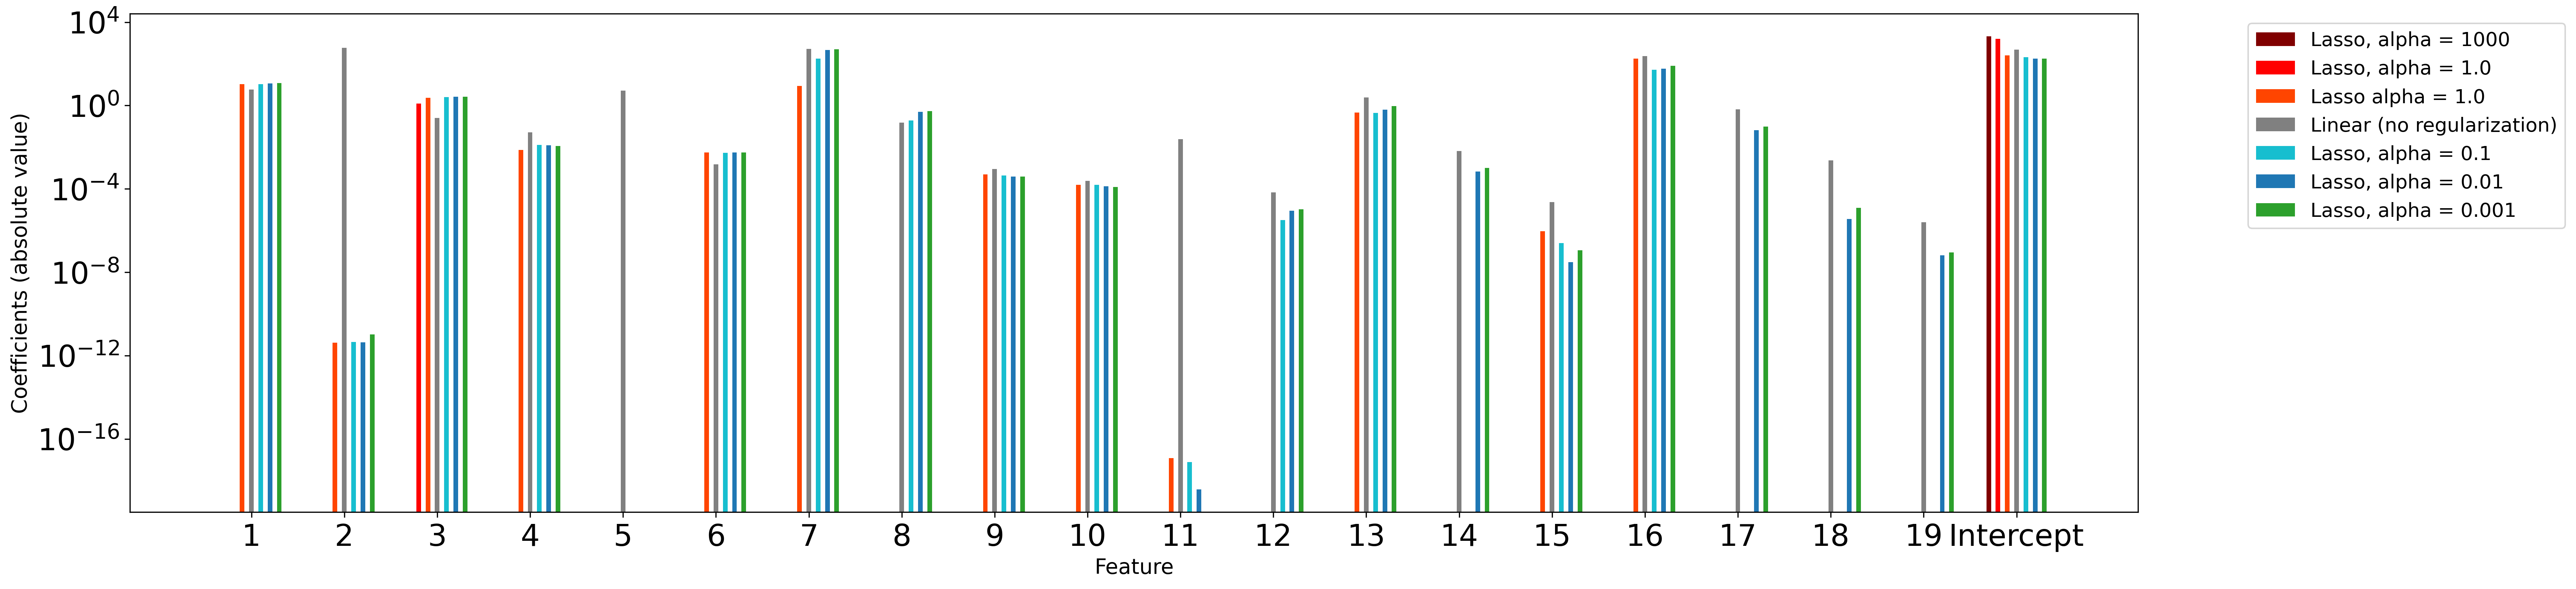

In [93]:
L1000 = Lasso(alpha = 1000, max_iter = 1000000, tol = 0.005, normalize=True)
L1000.fit(new_xb, ypb)
coef_L1000 =  np.hstack([L1000.coef_, L1000.intercept_])
print("coef_L1000 = {}".format(coef_L1000))

L100 = Lasso(alpha = 100, max_iter = 1000000, tol = 0.005, normalize=True)
L100.fit(new_xb, ypb)
coef_L100 =  np.hstack([L100.coef_, L100.intercept_])
print("coef_L100 = {}".format(coef_L100))

L1 = Lasso(alpha = 1.0, max_iter = 1000000, tol = 0.005, normalize=True)
L1.fit(new_xb, ypb)
coef_L1 = np.hstack([L1.coef_, L1.intercept_])
print("coef_L1 = {}".format(coef_L1))

L_1 = Lasso(alpha = 0.1, max_iter = 1000000, tol = 0.005, normalize=True)
L_1.fit(new_xb, ypb)
coef_L_1 = np.hstack([L_1.coef_, L_1.intercept_])
print("coef_L_1 = {}".format(coef_L_1))

L_01 = Lasso(alpha = 0.01, max_iter = 1000000, tol = 0.005, normalize=True)
L_01.fit(new_xb, ypb)
coef_L_01 = np.hstack([L_01.coef_, L_01.intercept_])
print("coef_L_01 = {}".format(coef_L_01))

L_001 = Lasso(alpha = 0.001, max_iter = 1000000, tol = 0.005, normalize=True)
L_001.fit(new_xb, ypb)
coef_L_001 = np.hstack([L_001.coef_, L_001.intercept_])
print("coef_L_001 = {}".format(coef_L_001))

coef_no_reg

plt.figure(figsize = (24,6))
plt.bar(np.arange(20)-0.3, np.abs(coef_L1000), color = 'maroon',    width=0.05, label = 'Lasso, alpha = 1000')
plt.bar(np.arange(20)-0.2, np.abs(coef_L100),  color = 'red',       width=0.05, label = 'Lasso, alpha = 1.0')
plt.bar(np.arange(20)-0.1, np.abs(coef_L1),    color = 'orangered', width=0.05, label = 'Lasso alpha = 1.0')
plt.bar(range(20), np.abs(coef_no_reg), color = 'grey',width=0.05, label = 'Linear (no regularization)')
plt.bar(np.arange(20)+0.1, np.abs(coef_L_1),   color = 'tab:cyan',  width=0.05, label = 'Lasso, alpha = 0.1')
plt.bar(np.arange(20)+0.2, np.abs(coef_L_01),  color = 'tab:blue',  width=0.05, label = 'Lasso, alpha = 0.01')
plt.bar(np.arange(20)+0.3, np.abs(coef_L_001), color = 'tab:green', width=0.05, label = 'Lasso, alpha = 0.001')

plt.yscale('log')
plt.xticks(np.arange(20), ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','Intercept'])  # Set text labels.
plt.xlabel('Feature',fontsize=14)
plt.ylabel('Coefficients (absolute value)',fontsize=14)
plt.legend(fontsize=13, bbox_to_anchor=(1.05, 1));